In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
print("Loading ratings data...")
ratings = pd.read_csv('../data/ml-25m/ratings.csv')

ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

print(f"Loaded {len(ratings):,} ratings")
print(f"Date range: {ratings['datetime'].min()} to {ratings['datetime'].max()}")
print("\nFirst few rows:")
ratings.head()

Loading ratings data...
Loaded 25,000,095 ratings
Date range: 1995-01-09 11:46:49 to 2019-11-21 09:15:03

First few rows:


,userId,movieId,rating,timestamp,datetime
0,1,296,5.0,1147880044,2006-05-17 15:34:04
1,1,306,3.5,1147868817,2006-05-17 12:26:57
2,1,307,5.0,1147868828,2006-05-17 12:27:08
3,1,665,5.0,1147878820,2006-05-17 15:13:40
4,1,899,3.5,1147868510,2006-05-17 12:21:50


In [3]:
split_date = '2015-01-01'

train = ratings[ratings['datetime'] < split_date].copy()
test = ratings[ratings['datetime'] >= split_date].copy()

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"\nSplit date: {split_date}")
print(f"\nTrain set:")
print(f"  - Size: {len(train):,} ratings")
print(f"  - Date range: {train['datetime'].min()} to {train['datetime'].max()}")
print(f"  - Percentage: {len(train)/len(ratings)*100:.1f}%")

print(f"\nTest set:")
print(f"  - Size: {len(test):,} ratings")
print(f"  - Date range: {test['datetime'].min()} to {test['datetime'].max()}")
print(f"  - Percentage: {len(test)/len(ratings)*100:.1f}%")

print(f"\nUnique users in train: {train['userId'].nunique():,}")
print(f"Unique users in test: {test['userId'].nunique():,}")
print(f"Unique movies in train: {train['movieId'].nunique():,}")
print(f"Unique movies in test: {test['movieId'].nunique():,}")

TRAIN/TEST SPLIT

Split date: 2015-01-01

Train set:
  - Size: 17,436,354 ratings
  - Date range: 1995-01-09 11:46:49 to 2014-12-31 23:49:53
  - Percentage: 69.7%

Test set:
  - Size: 7,563,741 ratings
  - Date range: 2015-01-01 00:02:15 to 2019-11-21 09:15:03
  - Percentage: 30.3%

Unique users in train: 121,673
Unique users in test: 45,450
Unique movies in train: 22,316
Unique movies in test: 58,133


In [4]:
train_users = set(train['userId'].unique())
test_users = set(test['userId'].unique())

train_movies = set(train['movieId'].unique())
test_movies = set(test['movieId'].unique())

new_users = test_users - train_users

new_movies = test_movies - train_movies

print("COLD START ANALYSIS")
print("="*60)
print(f"\nNew users in test (not in train): {len(new_users):,}")
print(f"New movies in test (not in train): {len(new_movies):,}")

print(f"\nPercentage of test ratings with new users: {(test['userId'].isin(new_users).sum() / len(test) * 100):.2f}%")
print(f"Percentage of test ratings with new movies: {(test['movieId'].isin(new_movies).sum() / len(test) * 100):.2f}%")

COLD START ANALYSIS

New users in test (not in train): 40,868
New movies in test (not in train): 36,731

Percentage of test ratings with new users: 90.38%
Percentage of test ratings with new movies: 12.99%


In [5]:
def calculate_rmse(actual, predicted):
    """
    Calculate Root Mean Square Error
    
    Lower is better. Measures average prediction error.
    """
    return np.sqrt(mean_squared_error(actual, predicted))

def calculate_mae(actual, predicted):
    """
    Calculate Mean Absolute Error
    
    Lower is better. Average absolute difference between actual and predicted.
    """
    return mean_absolute_error(actual, predicted)

actual_test = np.array([5.0, 4.0, 3.0, 2.0, 1.0])
predicted_test = np.array([4.5, 4.0, 3.5, 2.5, 1.5])

print("Testing evaluation metrics with dummy data:")
print(f"Actual:    {actual_test}")
print(f"Predicted: {predicted_test}")
print(f"\nRMSE: {calculate_rmse(actual_test, predicted_test):.4f}")
print(f"MAE:  {calculate_mae(actual_test, predicted_test):.4f}")
print("\nMetrics working correctly!")

Testing evaluation metrics with dummy data:
Actual:    [5. 4. 3. 2. 1.]
Predicted: [4.5 4.  3.5 2.5 1.5]

RMSE: 0.4472
MAE:  0.4000

Metrics working correctly!


In [6]:
global_avg = train['rating'].mean()

print("="*60)
print("BASELINE MODEL 1: GLOBAL AVERAGE")
print("="*60)
print(f"\nGlobal average rating: {global_avg:.4f}")

test_predictions_global = np.full(len(test), global_avg)

rmse_global = calculate_rmse(test['rating'].values, test_predictions_global)
mae_global = calculate_mae(test['rating'].values, test_predictions_global)

print(f"\nTest Set Performance:")
print(f"  RMSE: {rmse_global:.4f}")
print(f"  MAE:  {mae_global:.4f}")

print("\nExample predictions:")
print(f"  User 1, Movie A → Predicted: {global_avg:.2f}")
print(f"  User 2, Movie B → Predicted: {global_avg:.2f}")
print(f"  User 3, Movie C → Predicted: {global_avg:.2f}")
print("  (All predictions are the same!)")

BASELINE MODEL 1: GLOBAL AVERAGE

Global average rating: 3.5256

Test Set Performance:
  RMSE: 1.0810
  MAE:  0.8416

Example predictions:
  User 1, Movie A → Predicted: 3.53
  User 2, Movie B → Predicted: 3.53
  User 3, Movie C → Predicted: 3.53
  (All predictions are the same!)


In [8]:
# Calculate average rating per user from training data
user_avg = train.groupby('userId')['rating'].mean()

print("="*60)
print("BASELINE MODEL 2: USER AVERAGE")
print("="*60)
print(f"\nNumber of users with averages: {len(user_avg):,}")
print(f"\nExample user averages:")
print(user_avg.head(10))

def predict_user_average(user_id):
    """
    Predict based on user's average rating.
    If user not in training, use global average (cold start).
    """
    if user_id in user_avg.index:
        return user_avg[user_id]
    else:
        return global_avg

test_predictions_user = test['userId'].apply(predict_user_average).values

rmse_user = calculate_rmse(test['rating'].values, test_predictions_user)
mae_user = calculate_mae(test['rating'].values, test_predictions_user)

print(f"\nTest Set Performance:")
print(f"  RMSE: {rmse_user:.4f}")
print(f"  MAE:  {mae_user:.4f}")

print(f"\nImprovement over Global Average:")
print(f"  RMSE: {rmse_global:.4f} → {rmse_user:.4f} ({((rmse_global - rmse_user) / rmse_global * 100):.2f}% better)")
print(f"  MAE:  {mae_global:.4f} → {mae_user:.4f} ({((mae_global - mae_user) / mae_global * 100):.2f}% better)")

BASELINE MODEL 2: USER AVERAGE

Number of users with averages: 121,673

Example user averages:
userId
1     3.814286
2     3.630435
5     3.752475
6     4.153846
7     3.640000
8     3.612903
9     3.865169
10    3.452830
11    3.145833
12    3.296196
Name: rating, dtype: float64

Test Set Performance:
  RMSE: 1.0782
  MAE:  0.8390

Improvement over Global Average:
  RMSE: 1.0810 → 1.0782 (0.26% better)
  MAE:  0.8416 → 0.8390 (0.30% better)


In [9]:
test_with_predictions = test.copy()
test_with_predictions['has_user_history'] = test['userId'].isin(user_avg.index)

print("Prediction Strategy Breakdown:")
print(f"Used user average: {test_with_predictions['has_user_history'].sum():,} ({test_with_predictions['has_user_history'].sum()/len(test)*100:.2f}%)")
print(f"Used global fallback: {(~test_with_predictions['has_user_history']).sum():,} ({(~test_with_predictions['has_user_history']).sum()/len(test)*100:.2f}%)")

Prediction Strategy Breakdown:
Used user average: 727,415 (9.62%)
Used global fallback: 6,836,326 (90.38%)


In [11]:
movie_avg = train.groupby('movieId')['rating'].mean()

print("="*60)
print("BASELINE MODEL 3: MOVIE AVERAGE")
print("="*60)
print(f"\nNumber of movies with averages: {len(movie_avg):,}")
print(f"\nExample movie averages:")
print(movie_avg.head(10))

def predict_movie_average(movie_id):
    """
    Predict based on movie's average rating.
    If movie not in training, use global average (cold start).
    """
    if movie_id in movie_avg.index:
        return movie_avg[movie_id]
    else:
        return global_avg

test_predictions_movie = test['movieId'].apply(predict_movie_average).values

rmse_movie = calculate_rmse(test['rating'].values, test_predictions_movie)
mae_movie = calculate_mae(test['rating'].values, test_predictions_movie)

print(f"\nTest Set Performance:")
print(f"  RMSE: {rmse_movie:.4f}")
print(f"  MAE:  {mae_movie:.4f}")

print(f"\nImprovement over Global Average:")
print(f"  RMSE: {rmse_global:.4f} → {rmse_movie:.4f} ({((rmse_global - rmse_movie) / rmse_global * 100):.2f}% better)")
print(f"  MAE:  {mae_global:.4f} → {mae_movie:.4f} ({((mae_global - mae_movie) / mae_global * 100):.2f}% better)")

test_with_movie_history = test['movieId'].isin(movie_avg.index)
print(f"\nPrediction Strategy:")
print(f"Used movie average: {test_with_movie_history.sum():,} ({test_with_movie_history.sum()/len(test)*100:.2f}%)")
print(f"Used global fallback: {(~test_with_movie_history).sum():,} ({(~test_with_movie_history).sum()/len(test)*100:.2f}%)")

BASELINE MODEL 3: MOVIE AVERAGE

Number of movies with averages: 22,316

Example movie averages:
movieId
1     3.920332
2     3.212593
3     3.151179
4     2.868021
5     3.064212
6     3.835926
7     3.368697
8     3.140239
9     3.013139
10    3.427343
Name: rating, dtype: float64

Test Set Performance:
  RMSE: 1.0186
  MAE:  0.7740

Improvement over Global Average:
  RMSE: 1.0810 → 1.0186 (5.78% better)
  MAE:  0.8416 → 0.7740 (8.03% better)

Prediction Strategy:
Used movie average: 6,581,236 (87.01%)
Used global fallback: 982,505 (12.99%)


BASELINE MODEL COMPARISON
         Model     RMSE      MAE
Global Average 1.081027 0.841569
  User Average 1.078201 0.839036
 Movie Average 1.018584 0.774030


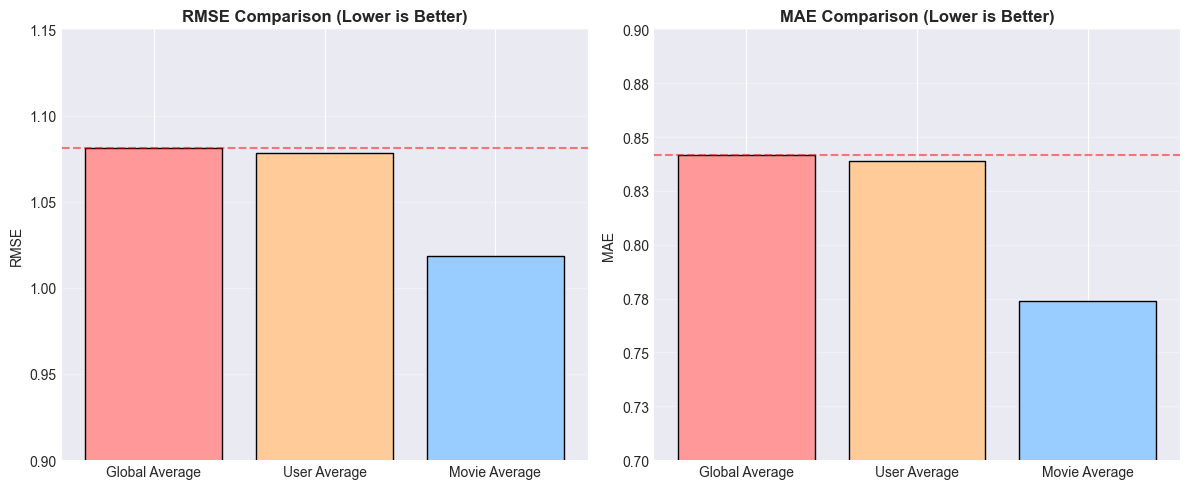


Best baseline model: Movie Average
Target for SVD: Beat RMSE = 1.0186


In [13]:
results = pd.DataFrame({
    'Model': ['Global Average', 'User Average', 'Movie Average'],
    'RMSE': [rmse_global, rmse_user, rmse_movie],
    'MAE': [mae_global, mae_user, mae_movie]
})

print("="*60)
print("BASELINE MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(results['Model'], results['RMSE'], color=['#ff9999', '#ffcc99', '#99ccff'], edgecolor='black')
ax1.set_title('RMSE Comparison (Lower is Better)', fontweight='bold')
ax1.set_ylabel('RMSE')
ax1.set_ylim(0.9, 1.15)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=rmse_global, color='red', linestyle='--', alpha=0.5, label='Global Baseline')

ax2.bar(results['Model'], results['MAE'], color=['#ff9999', '#ffcc99', '#99ccff'], edgecolor='black')
ax2.set_title('MAE Comparison (Lower is Better)', fontweight='bold')
ax2.set_ylabel('MAE')
ax2.set_ylim(0.7, 0.9)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))  # 2 decimal places
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=mae_global, color='red', linestyle='--', alpha=0.5, label='Global Baseline')

plt.tight_layout()
plt.show()

print(f"\nBest baseline model: Movie Average")
print(f"Target for SVD: Beat RMSE = {rmse_movie:.4f}")

## Summary: Baseline Models

### Dataset Split
- **Train:** 17.4M ratings (1995-2014, 70%)
- **Test:** 7.5M ratings (2015-2019, 30%)

### Cold Start Challenge
- **New users in test:** 90.38% (major challenge)
- **New movies in test:** 12.99% (manageable)

### Baseline Performance

| Model | RMSE | MAE | Improvement |
|-------|------|-----|-------------|
| Global Average | 1.0810 | 0.8416 | Baseline |
| User Average | 1.0782 | 0.8390 | 0.26% better |
| Movie Average | **1.0186** | **0.7740** | **5.78% better** |

### Key Insights
1. **Movie Average is best baseline** - Uses movie quality, handles cold start better (87% coverage)
2. **User Average barely improves** - 90% cold start forces fallback to global average
3. **Target for SVD:** Must beat RMSE = 1.0186

### Next Steps (Day 4)
- Implement SVD (Singular Value Decomposition)
- Matrix factorization to learn latent factors
- Goal: RMSE < 0.90